## Kaggle API Integration

In [1]:

!pip install -q kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = 'C:/Users/sanja/Documents/PBI/Project'

Let's use Kaggle's API to download the datasets

In [2]:
!kaggle datasets download -d gpreda/covid-world-vaccination-progress
!kaggle datasets download -d sudalairajkumar/undata-country-profiles



  0%|          | 0.00/148k [00:00<?, ?B/s]
100%|██████████| 148k/148k [00:00<00:00, 2.27MB/s]


  0%|          | 0.00/42.3k [00:00<?, ?B/s]
100%|██████████| 42.3k/42.3k [00:00<00:00, 1.06MB/s]


Let's Extract the data from zip files

In [3]:

from zipfile import ZipFile
filename1 = "covid-world-vaccination-progress.zip"
filename2 = "undata-country-profiles.zip"

with ZipFile(filename1, 'r') as zipf:
    zipf.extractall()
    print("Extracting the dataset 1... Done")

with ZipFile(filename2, 'r') as zipf:
    zipf.extractall()
    print("Extracting the dataset 2... Done")

Extracting the dataset 1... Done
Extracting the dataset 2... Done


Now we will delete the extra unwanted files

In [4]:
!del covid-world-vaccination-progress.zip
!del undata-country-profiles.zip
print("Removed the zip files..")
!del kiva_country_profile_variables.csv
print("Kiva data removed")

Removed the zip files..
Kiva data removed


## Pre-processing Using Interpolation for Missing Data

We will use pandas library for easy data manipulation

In [5]:
import pandas as pd

Let's read the downloaded csv file

In [6]:
vac_data = pd.read_csv('country_vaccinations.csv')

First we check for missing values

In [7]:
vac_data.date = pd.to_datetime(vac_data.date)
vac_data.isna().sum()

country                                   0
iso_code                                  0
date                                      0
total_vaccinations                     2502
people_vaccinated                      2960
people_fully_vaccinated                4169
daily_vaccinations_raw                 3169
daily_vaccinations                      195
total_vaccinations_per_hundred         2502
people_vaccinated_per_hundred          2960
people_fully_vaccinated_per_hundred    4169
daily_vaccinations_per_million          195
vaccines                                  0
source_name                               0
source_website                            0
dtype: int64

We will use linaer interpolation to fill out the missing values

In [8]:
vac_data_interpolated = vac_data.groupby('country').apply(lambda group: group.interpolate('linear', limit_direction='forward'))
vac_data_interpolated.isna().sum()

country                                   0
iso_code                                  0
date                                      0
total_vaccinations                       38
people_vaccinated                       957
people_fully_vaccinated                3324
daily_vaccinations_raw                 2133
daily_vaccinations                      183
total_vaccinations_per_hundred           38
people_vaccinated_per_hundred           957
people_fully_vaccinated_per_hundred    3324
daily_vaccinations_per_million          183
vaccines                                  0
source_name                               0
source_website                            0
dtype: int64

The leading missing values are filled with 0s, and the interpolations are rounded to the nearest integers

In [9]:
vac_data_interpolated.fillna(0, inplace=True)
vac_data_interpolated = vac_data_interpolated.round()
vac_data_interpolated

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
1,Albania,ALB,2021-01-11,64.0,64.0,0.0,0.0,64.0,0.0,0.0,0.0,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
2,Albania,ALB,2021-01-12,128.0,128.0,0.0,0.0,64.0,0.0,0.0,0.0,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
3,Albania,ALB,2021-01-13,188.0,188.0,0.0,60.0,63.0,0.0,0.0,0.0,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
4,Albania,ALB,2021-01-14,266.0,266.0,0.0,78.0,66.0,0.0,0.0,0.0,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6740,Zimbabwe,ZWE,2021-03-12,36283.0,36283.0,0.0,264.0,708.0,0.0,0.0,0.0,48.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1371917996...
6741,Zimbabwe,ZWE,2021-03-13,36359.0,36359.0,0.0,76.0,621.0,0.0,0.0,0.0,42.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1371917996...
6742,Zimbabwe,ZWE,2021-03-14,36359.0,36359.0,0.0,0.0,588.0,0.0,0.0,0.0,40.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1371917996...
6743,Zimbabwe,ZWE,2021-03-15,37660.0,37660.0,0.0,1301.0,306.0,0.0,0.0,0.0,21.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1371917996...


Let's save the resulting CSV for future processing

In [10]:
vac_data_interpolated.to_csv('vac_data_interpolated.csv', index=False)

## Daily Vaccination Rates of Different Countries

Let's use pygal package for all the plots and graphs

In [11]:
!pip install pygal
!pip install pygal_maps_world

In [12]:
import pygal
config = pygal.Config()
config.show_legend = True

Read in the pre-processed data

In [13]:
numbersdf = pd.read_csv('vac_data_interpolated.csv')
numbersdf.date = pd.to_datetime(numbersdf.date)

A helper function to find country code

In [14]:
def get_code(country_name):
    for code, name in pygal.maps.world.COUNTRIES.items():
        if name == country_name:
            return code
    return None

List of chosen countries to explore and filter the dataframe

In [15]:
explore_list = sorted(['Israel', 'Chile', 'United States', 'Brazil', 'United Kingdom', 'United Arab Emirates', 'Spain', 'Russia', 'Bahrain', 'France', 'India', 'China'])
exploredf = numbersdf.loc[numbersdf.country.isin(explore_list)]

Plotting a line plot of the daily vaccinations per million of the chosen countries

In [16]:
daily_line_chart = pygal.Line()
daily_line_chart.title = 'Daily Vaccinations per Million'
daily_line_chart.x_labels = exploredf.loc[exploredf.country == 'United Kingdom', 'date']
for c in explore_list:
    daily_line_chart.add(c, exploredf.loc[exploredf.country == c, 'daily_vaccinations_per_million'])
daily_line_chart.render_to_file(daily_line_chart.title + '.svg') 

Using a `Hash Map` data structure to store the country-wise daily vaccination rate

In [17]:
table_map = {}
for c in explore_list:
    table_map[get_code(c)] = exploredf.loc[exploredf.country == c].iloc[-1]['daily_vaccinations_per_million']

Plot the data extracted into the hash map in a world chart

In [18]:
dark_rotate_style = pygal.style.RotateStyle('#9e6ffe')
worldmap_chart = pygal.maps.world.World(style=pygal.style.CleanStyle)
worldmap_chart.title = 'Daily Vaccinations per Million - Current'
worldmap_chart.add('Selected 12', table_map)
worldmap_chart.render_to_file(worldmap_chart.title + '.svg')

Extract the list of manufacturers from the data from the chosen countries

In [19]:
manufacturers = set()
for cm in exploredf.vaccines.unique():
    manufacturers.update(cm.split(', '))

Build another hash map which contains the list of manufacturers for the chosen countries

In [20]:
manu_map = {}
for m in manufacturers:
    manu_map[m] = []
    manu_map[m] += list(exploredf.loc[exploredf.vaccines.str.contains(m)].country.unique())

Let's plot the manufacturer data on a world chart

In [21]:
manufacturer_chart = pygal.maps.world.World()
manufacturer_chart.title = 'Vaccine Manufacturers Used'
for m, l in manu_map.items():
    manufacturer_chart.add(m, dict(zip(list(map(lambda x: get_code(x), l)), [1]*len(l))))
manufacturer_chart.render_to_file(manufacturer_chart.title + '.svg')

## Using heaps to find the most vaccinated Country and date

Importing heap and numpy library

In [74]:
import heapq
import numpy

read the csv data for date and vaccinations per million

In [146]:
input_df = pd.read_csv('vac_data_interpolated.csv')
input_df1 = input_df[['daily_vaccinations_per_million','date','country']]
input_df1 = input_df1[input_df1.country.isin(pygal.maps.world.COUNTRIES.values())]

read the csv data for country and vaccinations per million and group by country

In [147]:
input_df2 = input_df[['country','daily_vaccinations_per_million']]
grouped_data = input_df2.groupby('country',as_index=False)['daily_vaccinations_per_million'].sum()
grouped_data = grouped_data[grouped_data.country.isin(pygal.maps.world.COUNTRIES.values())]
subset = grouped_data[['daily_vaccinations_per_million','country']]

Creating tuples for each pair of (vaccinations per million, date) and (vaccinations per million, country)

In [148]:
print(grouped_data.sort_values(by=['daily_vaccinations_per_million'],ascending = False))

                  country  daily_vaccinations_per_million
61                 Israel                       1077388.0
112            Seychelles                        880313.0
129  United Arab Emirates                        583144.0
81                 Monaco                        385303.0
130        United Kingdom                        374483.0
..                    ...                             ...
124               Tunisia                           223.0
3                  Angola                           189.0
67                  Kenya                           138.0
127                Uganda                            43.0
35                  Egypt                            12.0

[105 rows x 2 columns]


In [149]:
tuples_date = [tuple(x) for x in input_df1.to_numpy()]
tuples_country = [tuple(x) for x in subset.to_numpy()]

heapq library in python creates min heap by default so let's negate the values of vaccinations to create a max heap

In [150]:
mod_tuples_date = list(map(lambda x: (-x[0], x[1], x[2]), tuples_date))
mod_tuples_country = list(map(lambda x: (-x[0], x[1]), tuples_country))

Creating a min heap with negated values

In [151]:
heapq.heapify(mod_tuples_date)
heapq.heapify(mod_tuples_country)

Get the top of the heap and return its negation to give the maximum vaccinations per million

In [152]:
max_val2 = (heapq.heappop(mod_tuples_date))
print("On",max_val2[1],max_val2[2],"did",-1*max_val2[0],"vaccinations per million.")

On 2021-02-13 Seychelles did 24415.0 vaccinations per million.


In [153]:
max_val = (heapq.heappop(mod_tuples_country))
print(max_val[1],"with",-1*max_val[0],"vaccinations per million is most vaccinated country")

Israel with 1077388.0 vaccinations per million is most vaccinated country


## Representing donations and puchase of vaccines

In [77]:
df_donations_purchase= pd.read_excel("Supply_210312.xlsx",sheet_name=1)


Remove blank values from required columns

In [78]:

df_donations_purchase2 = df_donations_purchase.dropna(subset=['Organisations', 'Countries','Purchase Type','Supply Number'])

Replace same values with a common name

In [79]:
df_replace = df_donations_purchase2.replace({'Serum Institute of India;Government of India':'Government of India', 'Government of India;Serum Institute of India':'Government of India'})


Extract Data for donations

In [80]:
df_donations = df_replace.loc[df_replace['Purchase Type']=="Donation"]
df_donations = df_donations[['Organisations','Countries','Supply Number']]

Plotting number of vaccinations donationed by countries

In [82]:
dark_rotate_style = pygal.style.RotateStyle('#6E4DB1')
worldmap_chart_donations = pygal.maps.world.World(style=dark_rotate_style)
worldmap_chart_donations.title = 'Vaccine Donations'
for name, group in df_donations.groupby('Organisations'):
    worldmap_chart_donations.add(name, list(map(lambda kv: (get_code(kv[0]), kv[1]), group.set_index('Countries')['Supply Number'].to_dict().items())))
worldmap_chart_donations.render_to_file('Vaccine Donations.svg')

Extracting donations for purchase

In [83]:
df_purchases = df_replace[(df_replace['Purchase Type']=="Purchase")]
df_purchases = df_purchases[['Organisations','Countries','Supply Number']] 

In [ ]:
Plotting numberb of vaccinations purchased by countries 

In [84]:
worldmap_chart_purchases = pygal.maps.world.World(style=dark_rotate_style)
worldmap_chart_purchases.title = 'Vaccine Purchases'
for name, group in df_purchases.groupby('Organisations'):
    worldmap_chart_purchases.add(name, list(map(lambda kv: (get_code(kv[0]), kv[1]), group.set_index('Countries')['Supply Number'].to_dict().items())))
worldmap_chart_purchases.render_to_file('Vaccine Purchases.svg')

## Linear Regression of Daily Vaccination

In [85]:
import pandas as pd
import datetime as dt

we use pandas to build dataframe for linear regression and import datetime to convert date into epoch time

In [86]:
vac_data = pd.read_csv('vac_data_interpolated.csv')

In [87]:
vac_data['date'] = pd.to_datetime(vac_data['date'])
vac_data['x'] = (vac_data['date'] - dt.datetime(1970,1,1)).dt.total_seconds() 
vac_data['x2'] = vac_data['x']**2
vac_data['people_fully_vaccinated'] = vac_data['people_fully_vaccinated']**3 

In this cell we are converting date string into Epoch time, adding a dummy variable for regression, and adding people_fully_vaccinated as the third feature.

In [88]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

we will use sklearn for linear regression and matplotlib for plotting

In [89]:
gcs = vac_data.groupby('country')

we make sub-groups of dataframe by country name using group_by

In [90]:
explore_list = sorted(['Israel', 'Chile', 'United States', 'Brazil', 'United Kingdom', 'United Arab Emirates', 'Spain', 'Russia', 'Bahrain', 'France', 'India', 'China'])

We have these twelve countries selected to be observed and probed.

In [91]:
def predict_on(day, total_vaccinations):
    seconds = (day - dt.datetime(1970,1,1)).total_seconds()
    print(reg.predict([[seconds, seconds ** 2, total_vaccinations]])[0])

This function aims to return the total vaccination taken a given date and total vaccinations

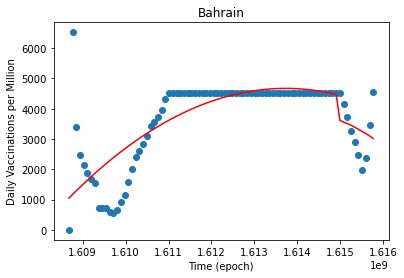

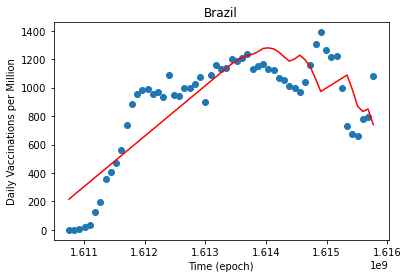

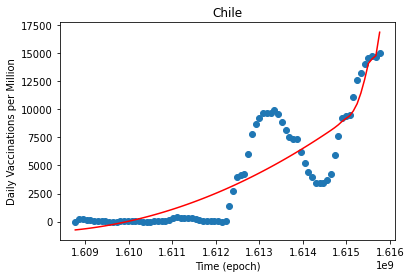

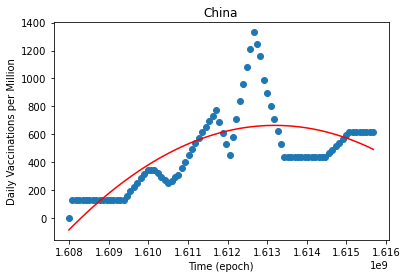

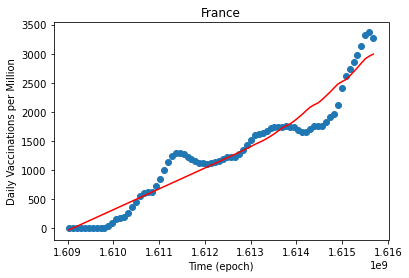

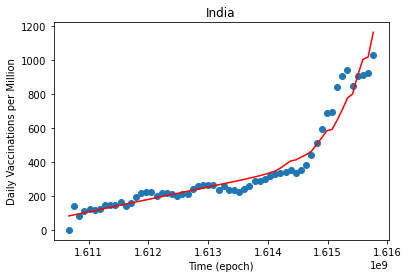

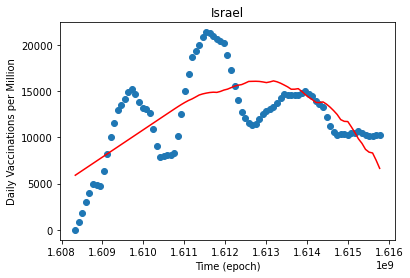

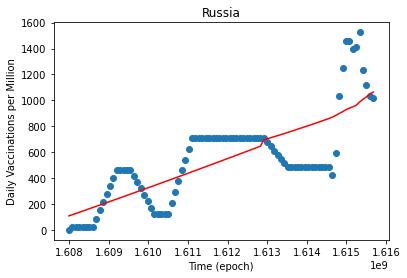

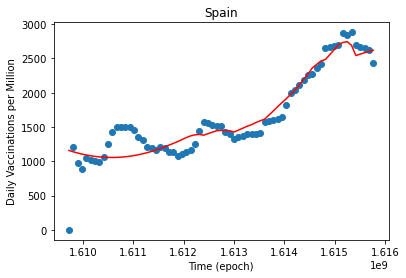

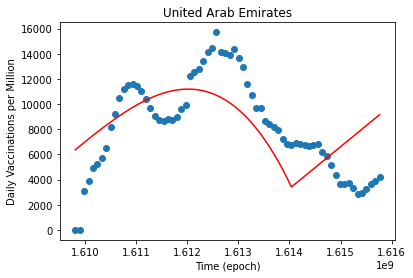

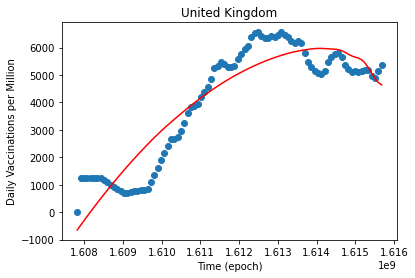

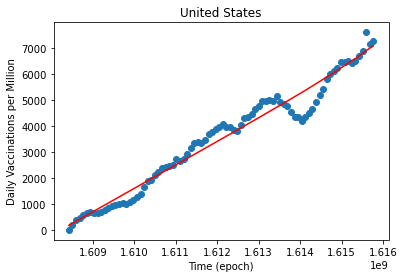

In [93]:
for c in explore_list:
    gc = gcs.get_group(c) 
    reg = LinearRegression().fit(gc[['x', 'x2', 'people_fully_vaccinated']], gc['daily_vaccinations_per_million'])
    plt.scatter(gc['x'], gc['daily_vaccinations_per_million'])
    plt.plot(gc['x'], reg.predict(gc[['x', 'x2', 'people_fully_vaccinated']]), 'r')
    plt.title(c)
    plt.ylabel('Daily Vaccinations per Million')
    plt.xlabel('Time (epoch)')
    #predict_on(dt.datetime(2021, 4, 4), 100000)
    plt.show()

We iterate through the selected countries to look at their daily vaccination trends. 